# **Computer Vision 600.661: Homework 2**
## **2D Transformations**

### Dimitri Lezcano

### **Imports**

In [203]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

# helpful for grabbing different colors
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]
color_names = ['red', 'green', 'blue', 'yellow', 'purple', 'teal']

### *Previous Functions*

Affine Transformations

In [2]:
def affine_2d_Ab(X, Y):
    ''' create the A matrix for affine transformation
    
        Args:
            - X: the source points ( N x 2 )
            - Y: the target points ( N x 2 )
            
        Returns:
            - A: the A (2*N x 6) matrix for least squares formulation
            - b: the b (2*N) vector for least squares formulation
    
    '''
    # initialize the matrices
    A = np.zeros( ( 2*X.shape[0], 6 ) )
    b = Y.reshape(-1)
    
    Xh = np.hstack( ( X, np.ones( ( X.shape[0], 1 ) ) ) )
#     Yh = np.hstack( ( Y, np.ones( ( X.shape[0], 1 ) ) ) )

    A[0::2, :3] = Xh
    A[1::2, 3:] = Xh
    
    
    
    return A, b
    
# affine_2d_Ab

def get_affinetransform(X, Y):
    ''' wrapper function for ease of use for affine transform'''
    A, b = affine_2d_Ab(source, target)
    t = la.inv(A.T @ A) @ A.T @ b # transform vector
    affine_transform = np.vstack((t.reshape(2,3), [0, 0, 1]))
    
    return affine_transform

# get_affinetransform

Homographies

In [3]:
def homography_2d_A(X, Y):
    ''' create the A matrix for homography transformation
    
        Args:
            - X: the source points ( N x 2 )
            - Y: the target points ( N x 2 )
            
        Returns:
            - A: the A (2*N x 9) matrix for least squares formulation
    
    '''
    # initialize the matrices
    A = np.zeros( ( 2*X.shape[0], 9 ) )
    
    Xh = np.hstack( ( X, np.ones( ( X.shape[0], 1 ) ) ) )

    A[:, 0:6] = affine_2d_Ab(X, Y)[0] 
    
    A[0::2, 6:] = -Y[:,0].reshape(-1,1) * Xh
    A[1::2, 6:] = -Y[:,1].reshape(-1,1) * Xh
    
    return A
    
# homography_2d_A

def solveA_svd(A):
    ''' Function to return the solution of:
        
        argmin_x ||A x||^2 
        
        Args:
            - A: the matrix
            
        Return:
            - x = argmin of above 1-D vector
            - s = the associated singular value
    
    '''
    # perform the svd of A
    u, s, vh = la.svd(A)
    
    # last singular value is the smallest 
    s_min = s[-1]
    v_min = vh[-1,:]
    v_min = v_min/la.norm(v_min)
    
    return v_min, s_min
    
# solveA_svd

def get_homography(X, Y):
    ''' wrapper function for ease of use for homography'''
    A = homography_2d_A(X, Y)

    t, s = solveA_svd(A)
    T = t.reshape(3,3)
    
    return T

# get_homography

def apply_homography(T, X):
    ''' applies homography to row-wise coordinates
        
        Args:
            - T  ( 3 x 3 ) homography transform
            - X  ( N x 2 ) points to be transform
    
    '''
    Xh = np.hstack( (X, np.ones((X.shape[0], 1)) ) )
    
    Yh = Xh @ T.T # project coordinates
    
    Yh /= Yh[:,-1].reshape(-1, 1) # normalize the scale coordinate
    
    return Yh[:,0:2]

# apply_homography    

Gradient Histogramming

In [4]:
def gradient_histw(grads, n_bins = 10, plot:bool=False):
    ''' function to compute the weighted histogram of gradients
        
        Args:
            - grads: [N x 2] array of (x, y) gradient vectors
            - n_binds: integer of the number of bins to use (Default = 10)
            - plot: plotting argument
            
        Returns:
            - theta: a `n_bins`-vector of the directions of gradients
            - histw: a `n_bins`-vector of the weighted histogram
            
    
    '''
    # compute theta array
    theta = np.linspace(0, 2*np.pi, n_bins)
    
    # compute gradient directions and magnitudes
    theta_grads = np.arctan2(grads[:,1], grads[:,0])
    mag_grads = la.norm(grads, axis=1)
    
    # reorient so angles are between 0 and 2*pi
    theta_grads[theta_grads < 0] += 2*np.pi
    
    # compute a histogram
    histw, bins = np.histogram(theta_grads, bins=theta, weights=mag_grads)
    
    if plot:
        plt.hist(np.rad2deg(theta_grads), bins=np.rad2deg(theta), weights=mag_grads)
        plt.xlabel('theta (degs)')
        plt.title('Histogram of Gradients')
    
    
    return theta, histw
    
# gradient_histw

### **2D Feature Detection and Matching**

The RANSAC Code Functions: Previous code

In [49]:
def get_keypoint_coord_from_match(matches, kp1, kp2, index):
    """ Gets the keypoint coordinates that correspond to matches[index].
      For example, if we want to get the coordinates of the keypoints corresponding
      to the 10th matching pair, we would be passing

              get_keypoint_coord_from_match(matches, kp1, kp2, 10)

      Then it will return keypoint1, keypoint2, where
      keypoint1: [x, y] coordinate of the keypoint in img1 that corresponds to matches[10]
      keypoint2: [x, y] coordinate of the keypoint in img2 that corresponds to matches[10]
    """
    keypoint1 = [kp1[matches[index].queryIdx].pt[0], kp1[matches[index].queryIdx].pt[1]]
    keypoint2 = [kp2[matches[index].trainIdx].pt[0], kp2[matches[index].trainIdx].pt[1]]
    return keypoint1, keypoint2

# get_keypoint_coord_from_match

def ransac(matches, kp1, kp2, num_samples: int = 6, num_trials: int = 3000,
           inlier_thresh: int = 5, return_num_inliers:bool = False):
    
    # Some parameters
    total_matches = len(matches)
    
    # To keep track of the best transformation
    xform = np.zeros((3, 3))
    most_inliers = 0

    # turn the keypts into a numpy array: rows are the x-y coordinates
    keypts1 = []
    keypts2 = []
    for idx in range(total_matches):
        keypt1, keypt2 = get_keypoint_coord_from_match(matches, kp1, kp2, idx)
        
        keypts1.append(keypt1)
        keypts2.append(keypt2)
    # for
    
    keypts1 = np.array(keypts1).astype(np.float32)
    keypts2 = np.array(keypts2).astype(np.float32)
    
    # Loop through num_trials times
    for i in range(num_trials):

        # Randomly choose num_samples indices from total number of matches
        choices = np.random.choice(total_matches, num_samples, replace=False)

        # Get the matching keypoint coordinates from those indices
        keypts1_choice = keypts1[choices,:]
        keypts2_choice = keypts2[choices,:]

        # get homography   
        xform_i = get_homography(keypts1_choice, keypts2_choice)

        # count the number of inliers
        keypts1_xform_i = apply_homography(xform_i, keypts1)
        dists_i = la.norm(keypts1_xform_i - keypts2, axis=1)
        num_inliers = np.count_nonzero(dists_i <= inlier_thresh)

        # If for this transformation we have found the most inliers update most_inliers and xform
        if num_inliers > most_inliers:
            most_inliers = num_inliers
            xform = np.copy(xform_i)

        # if

    # for
    
    if return_num_inliers:
        return xform, most_inliers
    
    else:
        return xform
    
# ransac

#### Part 1 (10 pts): Use the Orb feature detector together with your RANSAC code and homography detection described above to develop a system to compute the homography that relates two images. Test it on the first two images of the four three image series above and report the resulting transforms

In [50]:
def compute_img_homography(img1, img2, num_samples: int = 6, num_trials: int = 3000,
           inlier_thresh: int = 5):
    ''' Function to compute the image homography using RANSAC
        Computes transform to warp img1 -> img2
    
    '''
    
    # orb feature detector
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    
    # create a BFMather object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # match descriptors
    matches = bf.match(des1, des2)
    
    # sort them in the order of their distance
    matches = sorted(matches, key = lambda x: x.distance)
    
    xform = ransac(matches, kp1, kp2, num_samples=num_samples,
                  num_trials=num_trials, inlier_thresh=inlier_thresh)
    
    return xform

# compute_img_homography

Test the homography computation function

In [51]:
img_pair_tests = [['bikes1.png', 'bikes2.png'], ['graf1.png', 'graf2.png'], 
                  ['leuven1.png', 'leuven2.png'], ['wall1.png', 'wall2.png']]
directory = 'data/'

# test to see if you can compute identity homography
print('Test for identity checking')
for f_img1,_ in img_pair_tests:
    print('[{:s}, {:s}]'.format(f_img1, f_img1))
    img1 = cv2.imread(directory + f_img1, cv2.IMREAD_GRAYSCALE)
#     img2 = cv2.imread(directory + f_img2, cv2.IMREAD_GRAYSCALE)
    
    xform = compute_img_homography(img1, img1, num_trials=10)
    print('Close to 3x3 Identity:', np.isclose( xform/xform[-1,-1], np.eye(3)).all())
    print()
    
# for
    
# the actual testing between images
for f_img1, f_img2 in img_pair_tests:
    print('[{:s}, {:s}]'.format(f_img1, f_img2))
    img1 = cv2.imread(directory + f_img1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(directory + f_img2, cv2.IMREAD_GRAYSCALE)
    
    xform = compute_img_homography(img1, img2)
    print(xform)
    print()
# for

Test for identity checking
[bikes1.png, bikes1.png]
Close to 3x3 Identity: True

[graf1.png, graf1.png]
Close to 3x3 Identity: True

[leuven1.png, leuven1.png]
Close to 3x3 Identity: True

[wall1.png, wall1.png]
Close to 3x3 Identity: True

[bikes1.png, bikes2.png]
[[ 3.36665789e-02  5.74377372e-04  5.39694919e-01]
 [-3.41139401e-04  3.37077286e-02 -8.39844083e-01]
 [-3.23706704e-07  2.15401547e-07  3.34845382e-02]]

[graf1.png, graf2.png]
[[-1.15952021e-02 -3.59396357e-03  2.58723356e-01]
 [ 1.87329838e-03 -1.12775956e-02 -9.65726579e-01]
 [-7.38964399e-06  2.51982407e-06 -1.25036377e-02]]

[leuven1.png, leuven2.png]
[[ 1.29236048e-01 -2.44920687e-04  8.90132160e-01]
 [ 3.00623855e-04  1.30877078e-01 -3.95850007e-01]
 [-2.03875951e-06  6.74145617e-07  1.30906812e-01]]

[wall1.png, wall2.png]
[[ 8.39281629e-03  1.59206220e-04  5.19851665e-01]
 [-7.11531545e-04  1.11346154e-02  8.54047966e-01]
 [-2.50643586e-06 -1.71836593e-07  1.27030367e-02]]



#### Part 2 (10 pts): Write a function that, given a series of N images, computes the pairwise matches between them, and uses your inverse warping function from the Python notebook to warp all of the images to the common image plane of the middle image. Return the resulting transforms and the resulting mosaicked image using the four full three image series in the data set.

Inverse warping function: Previous Code

In [8]:
def get_pixel_contributions(x, y):
    """ Gets the overlapped pixels along with the relative contributions.
      Args:
        x: The x-coordinate
        y: The y-coordinate
      Return:
        pixel_contributions: List of [x, y, contribution] where (x, y) are the coordinates of
                             pixels that the input overlaps with.
    """

    pixel_contributions = []
    
    # find the ranges of x
    if int(x) == x and False: # integer
        range_x = [int(x)]
        
    else:
        range_x = [int(x), int(x) + 1]
        
    # find the ranges of y
    if int(y) == y and False: # integer
        range_y = [int(y)]
        
    else:
        range_y = [int(y), int(y) + 1]
        
    # iterate through the ranges
    for xi in range_x:
        for yi in range_y:
            # calculate the overlap
            overlap_x = 1-abs(x - xi)
            overlap_y = 1-abs(y - yi)
            
            # calculate the contribution
            contribute = overlap_x * overlap_y
            
            # add the contribution
            pixel_contributions.append([xi, yi, contribute])
            
        # for
    # for
    
    return np.array(pixel_contributions)

# get_pixel_contributions

def get_pixel_contributions_arr(X, Y):
    pixel_contributions = np.zeros((4*X.shape[0], 3))
    
    Xr = X.astype(int)
    Yr = Y.astype(int)
    
    Xrep = X.repeat(4)
    Yrep = Y.repeat(4)
    
    # set the x-coordinates
    pixel_contributions[0::4, 0] = Xr
    pixel_contributions[1::4, 0] = Xr
    pixel_contributions[2::4, 0] = Xr + 1
    pixel_contributions[3::4, 0] = Xr + 1
    
    # set the y-coordinates
    pixel_contributions[0::4, 1] = Yr
    pixel_contributions[2::4, 1] = Yr
    pixel_contributions[1::4, 1] = Yr + 1
    pixel_contributions[3::4, 1] = Yr + 1
    
    # measure the contributions
    overlap_x = 1 - np.abs(pixel_contributions[:,0] - Xrep)
    overlap_y = 1 - np.abs(pixel_contributions[:,1] - Yrep)
    
    pixel_contributions[:,2] = overlap_x * overlap_y
    
    return pixel_contributions
    
# get_pixel_contributions_arr

def inverse_warp(transform, image, cols:int= None, rows:int=None):
    
    # image checking
    if image.ndim < 3:
        image = np.expand_dims(image, 2).repeat(3, axis=2)
        
    # if
    
    elif image.shape[2] == 1:
        image = image.repeat(3, axis=2)
        
    # elif
    
    if cols is None:
        cols = image.shape[1]
    
    if rows is None:
        rows = image.shape[0]

    output_image = np.zeros((rows, cols, 3), dtype=float)

    # Invert the transformation matrix
    transform = la.inv(transform)
    
    # get the pixel coordinates
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    pts = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
    
    # transform the pixel coordinates
    pts_transformed = apply_homography(transform, pts) 
    
    # get the pixel contributions shape rows*cols x 4 x 3
    contributions = get_pixel_contributions_arr(pts_transformed[:,0], pts_transformed[:,1])
    idxs = contributions[:,0:2].astype(int)
    
    invalid_idxs = (idxs < 0).any(axis=1) | (idxs[:,1] >= image.shape[0]) | (idxs[:,0] >= image.shape[1])
    
    # cancel out contributions and default invalid index to origin
    contributions[invalid_idxs, :] = 0
    idxs = contributions[:,0:2].astype(int) # reset the idxs
    
    # get the contributions
    contrib_pxs = contributions[:,-1].reshape(-1,1) * image[idxs[:,1], idxs[:,0]]
    
    # perform the inverse warping 
    output_image[pts[:,1], pts[:,0]] += contrib_pxs[0::4]
    output_image[pts[:,1], pts[:,0]] += contrib_pxs[1::4]
    output_image[pts[:,1], pts[:,0]] += contrib_pxs[2::4]
    output_image[pts[:,1], pts[:,0]] += contrib_pxs[3::4]
        

    return output_image.astype(np.uint8)

# inverse_warp

Function for computing the pairwise homographies between the N images.

In [37]:
def blend_images(image1, image2):
    ''' Blends the images from image1 and image2
        We assume that the image1 warped into plane of image2
        
        Method: simple feather blending on overlaps
    '''
    # compute the alpha matrix
    a1 = np.any(image1 != 0, axis=2) * 1
    a2 = np.any(image2 != 0, axis=2) * 0.3
    
    alpha = np.expand_dims(a1 - a2, axis=2)
    alpha[alpha < 0] = 0
    
    # blend the images
    image = alpha * image1 + ( 1 - alpha) * image2
    
    return image.astype(int)

# blend_images

def pw_homography(images: list):
    ''' Computes the pairwise homography from the center image
    
        Args:
            - images: list of N images
            
        Returns:
            - list of warped images to the center image plane
            - list of homographies from the center image
            
    
    '''
    
    # get the center image
    center_img = images[len(images)//2]
    
    # compute pairwise homographies
    homographies = []
    for img in images:
        H = compute_img_homography(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.cvtColor(center_img, cv2.COLOR_BGR2GRAY),
                                   num_samples=10, inlier_thresh = 1.5, num_trials=6000) 
        homographies.append(H)
        
    # for
    
    warped_images = []
    for H, img in zip(homographies, images):
        warped_img = inverse_warp(H, img, cols=center_img.shape[1], rows=center_img.shape[0])
        warped_images.append(warped_img)
        
    # for

    mosaicked_img = warped_images[len(images)//2]
    for warped_img in warped_images:
        mosaicked_img = blend_images(warped_img, mosaicked_img)
    
    return mosaicked_img, warped_images, homographies

# pw_homography   



Compute the mosaicked images for the test sets

[(700, 1000, 3), (700, 1000, 3), (700, 1000, 3)]
[bikes1.png, bikes2.png]
[[-2.89198726e-02 -3.62006856e-04 -4.74892899e-01]
 [ 1.38069721e-04 -2.91796790e-02  8.78621833e-01]
 [ 9.55898027e-08 -5.63059268e-07 -2.85034305e-02]]
[bikes2.png, bikes2.png]
[[-5.77350269e-01  5.84974739e-15 -3.40668279e-12]
 [ 1.44909513e-16 -5.77350269e-01  1.31213479e-13]
 [ 9.77818022e-19 -1.69041619e-18 -5.77350269e-01]]
[bikes3.png, bikes2.png]
[[-3.67432108e-02  4.03775747e-04 -9.76707663e-01]
 [ 1.23918096e-05 -3.65037642e-02 -2.04905741e-01]
 [-3.38976254e-08  6.69914729e-07 -3.70543873e-02]]

[(320, 400, 3), (320, 400, 3), (320, 400, 3)]
[graf1.png, graf2.png]
[[ 1.11076335e-02  3.76760906e-03 -2.32424389e-01]
 [-2.22326808e-03  1.16282556e-02  9.72389725e-01]
 [ 5.43419309e-06 -1.29225919e-06  1.26250587e-02]]
[graf2.png, graf2.png]
[[ 5.77350269e-01 -2.07855300e-15  5.40568544e-13]
 [-2.98217191e-16  5.77350269e-01  1.34144203e-13]
 [ 1.71371635e-19 -3.65883934e-18  5.77350269e-01]]
[graf3.png, g

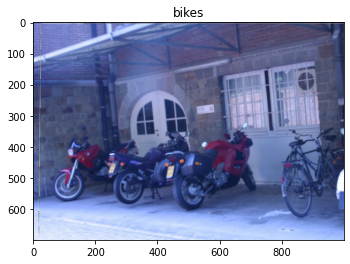

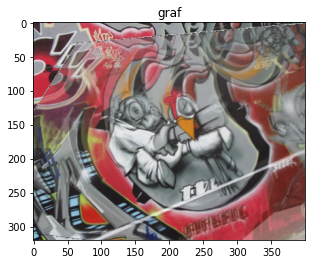

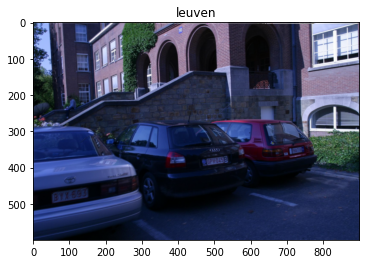

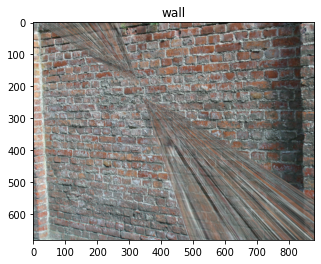

In [38]:
img_set_tests = [['bikes1.png', 'bikes2.png', 'bikes3.png'], ['graf1.png', 'graf2.png', 'graf3.png'], 
                  ['leuven1.png', 'leuven2.png', 'leuven3.png'], ['wall1.png', 'wall2.png', 'wall3.png']]

directory = 'data/'

for fimg_set in img_set_tests:
    img_set = [cv2.imread(directory + f, cv2.IMREAD_COLOR)[:,:,::-1] for f in fimg_set]
    
    
    # crop the images to the same size
    rows,cols = np.array([img.shape[0:2] for img in img_set]).min(axis=0)
    img_set = [img[:rows, :cols] for img in img_set]
    print([img.shape for img in img_set])
    
    mos_img, warped_imgs, homographies = pw_homography(img_set)
    
    for file, img, H in zip(fimg_set, img_set, homographies):
        print('[{:s}, {:s}]'.format(file, fimg_set[len(img_set)//2]))
        print(H)
    
    for file, wp_img in zip(fimg_set, warped_imgs):
        continue
        plt.figure()
        plt.imshow(wp_img)
        plt.title(file)
        plt.show()
    
    plt.figure()
    plt.imshow(mos_img)
    plt.title(file[:-5])
    print()
    
# for


#### **Part 3 (10 pts): Extend this to object detection**

Read the following OpenCV tutorial on object detection with SIFT:

* https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html
* https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

Using Orb, write a program which builds a dictionary indexed by file name of the first image of
each of the series of (bike, graf, leuven, wall) images. It should then read a new unseen image,
‘testimage.png’ and it should find all of the objects that are present in that image. Note this
could include duplicates! I’ve included an example, but you can easily generate your own test
data (hint, start simple and build up to something as complicated as what I’ve given you).

For full credit, your code should use RANSAC and homography estimation to detect consistent
features and thus be able to detect multiple instances of an object in the image. It should print
out the identity of the object(s) in the image, the coordinates of the bounding box of the detected
object, and it should draw the bounding boxes on the original image and display it.

Functions for object detection

In [237]:
def detect_object(query_img, object_db, match_thresh: int = 70, draw_features:bool = False):
    ''' Function to detect a single object in a query_img using the object's description.'''
    # sift detector
    sift = cv2.SIFT_create(nfeatures=20000)
        
    kp_qimg, des_qimg = sift.detectAndCompute(query_img, None)
    kp_qimg_pts = np.array([p.pt for p in kp_qimg]) # numpify the keypoint coordinates
    
    # cluster the points
    bandwidth = estimate_bandwidth(kp_qimg_pts, quantile=0.1, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(kp_qimg_pts)
    labels = ms.labels_
    n_clusters = len(np.unique(labels))
    
    if draw_features:
        draw_img = query_img.copy()

        
        for c, lbl in zip(colors[:n_clusters], np.unique(labels)):
            print('# labels of lbl = {:d}:'.format(lbl), np.count_nonzero(labels==lbl))
            for x, y in kp_qimg_pts[labels == lbl]:
                x = int(x)
                y = int(y)
                cv2.circle(draw_img, (x, y), 10, c, -1)
            #
        # for
        plt.figure(figsize=(12,8))
        plt.imshow(draw_img)
        plt.show()
    # if
    
    # iterate through each label
    objects = []
    for lbl in np.unique(labels):
        kpts_lbl = (np.array(kp_qimg)[labels == lbl]).tolist() # get the specitic key points
        des_lbl = des_qimg[labels == lbl]
        
        # find which object best matches this db
        best_score = 0 # number of inliers
        best_obj = None
        for obj_name, obj_desc in object_db.items():
            # get the object features keypoints and descriptors
            kp_obj = obj_desc['kp']
            des_obj = obj_desc['desc']

            # find the good matches
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(des_lbl, des_obj, k=2)
            
            good_matches = [m for m, n in matches if m.distance < 0.7*n.distance]
            
            
            # check if there are sufficient good matches
            if draw_features:
                print(lbl, obj_name, 'number of good matches:', len(good_matches))
                
            if len(good_matches) < match_thresh:
                continue
            
            # if
            
            # perform a ransac fitting to compute the homography
            xform, num_inliers = ransac(good_matches, kpts_lbl, kp_obj, num_samples = 12, inlier_thresh=1, return_num_inliers=True)
            
            # make sure to get the best num_inliers
            if num_inliers > best_score:
                best_obj = {'name': obj_name, 'transform': xform}
                
            # if
            
        # for
        
        # append the best score
        if best_obj is not None:
            objects.append((lbl, best_obj))
        # if
        
    # for
    
    # compute the bounding boxes
    for lbl, obj in objects:
        obj_name = obj['name']
        obj_shape = object_db[obj_name]['shape']
        pts = np.array([[0,            0],
                        [0,            obj_shape[0]],
                        [obj_shape[1], obj_shape[0]],
                        [obj_shape[1], 0]])
        
        new_pts = apply_homography(la.inv(obj['transform']), pts)
        obj['bound-box'] = new_pts
        
    # for
        
    
    return objects
    
# detect_object

Build the object look-up database

In [227]:
img_files = ['bikes1.png', 'graf1.png', 'leuven1.png', 'wall1.png']
directory = 'data/'

object_db = {}
# orb feature detector
sift = cv2.SIFT_create(nfeatures=2000)
for file in img_files:
    img = cv2.imread(directory + file, cv2.IMREAD_GRAYSCALE)
    kp, des = sift.detectAndCompute(img, None)
    object_db[file] = {'kp': kp, 'desc': des, 'shape': img.shape[0:2]}
    
# for

print(object_db['bikes1.png']['shape'])
print(des.shape)

(700, 1000)
(2000, 128)


Test the Object Detection code.

(2250, 4000, 3)
0 red wall1.png
bounding box:
[[1509.7024222  1334.02439314]
 [1989.41890354 2356.48516161]
 [3450.05884235 1671.13019205]
 [2970.08471298  649.0025703 ]]

1 green leuven1.png
bounding box:
[[1352.45560019   -4.9544998 ]
 [1352.47952355  859.83704947]
 [2648.51924284  860.49203443]
 [2647.59057759   -4.48752334]]

2 blue bikes1.png
bounding box:
[[2368.58489488  219.48160687]
 [1827.02472344  930.22113508]
 [2838.20129833 1708.36666749]
 [3386.4767451   993.77866916]]

3 yellow leuven1.png
bounding box:
[[ 1.35772053e+03 -2.56154154e+00]
 [ 1.35570817e+03  8.59308100e+02]
 [ 2.64729056e+03  8.60559599e+02]
 [ 2.64855273e+03 -4.89249676e+00]]

4 purple leuven1.png
bounding box:
[[1139.90381479  108.97279417]
 [ 393.42108018 1108.4531034 ]
 [1878.93451009 2247.96436653]
 [2655.0736522  1267.59880197]]



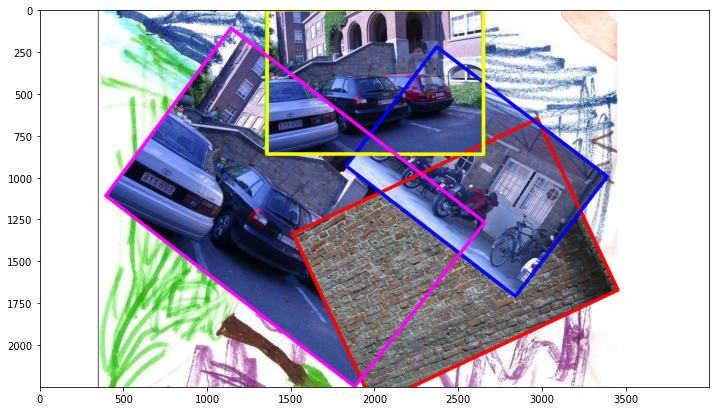

In [247]:
test_img = cv2.imread('data/testexample.jpg', cv2.IMREAD_COLOR)[:,:,::-1]

print(test_img.shape)

# plt.figure(figsize=(12,8))
# plt.imshow(test_img)

objs = detect_object(test_img, object_db, draw_features=False, match_thresh = 20)

draw_img = test_img.copy()
for lbl, obj in objs:
    c = colors[lbl] # grab a color
    bound_box = obj['bound-box'] # bounding box points
    
    print(lbl, color_names[lbl], obj['name'])
    print('bounding box:')
    print(bound_box)
    
    for i in range(4):
        p1 = bound_box[i].astype(int)
        p2 = bound_box[(i+1) % 4].astype(int)
        
        cv2.line(draw_img, tuple(p1), tuple(p2), c, int(0.005*max(test_img.shape)))
        
    # for
    
    print()
    
# for

plt.figure(figsize=(12,8))
plt.imshow(draw_img)


Simple Test case

(700, 1000, 3) (320, 400, 3)
(700, 2000, 3)
0 red graf1.png
bounding box:
[[1300.11956965  190.3496173 ]
 [1300.00164815  509.98613379]
 [1700.04623798  509.88878866]
 [1700.22268015  189.8943878 ]]

1 green bikes1.png
bounding box:
[[ -8.31716744 -19.19395775]
 [ -4.07912722 339.85168431]
 [505.29938105 335.96113324]
 [505.99277243 -17.73574327]]

2 blue bikes1.png
bounding box:
[[ -4.88961749 -19.99903195]
 [  1.48103992 337.70459313]
 [501.98202038 335.8496484 ]
 [507.1800854  -19.39299772]]

3 yellow bikes1.png
bounding box:
[[ -2.79507307 -16.66544354]
 [  1.71664441 338.02327801]
 [505.66960916 337.07350916]
 [506.70432107 -18.79559537]]



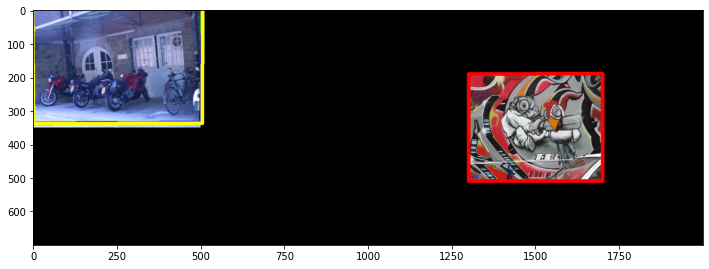

In [248]:
# construct the test image
test_img1 = cv2.imread('data/bikes3.png', cv2.IMREAD_COLOR)[:,:,::-1]
test_img2 = cv2.imread('data/graf1.png', cv2.IMREAD_COLOR)[:,:,::-1]
print(test_img1.shape, test_img2.shape)
pad_rows = int((test_img1.shape[0] - test_img2.shape[0])/2)
pad_cols = int((test_img1.shape[1] - test_img2.shape[1])/2)
test_img2 = np.pad(test_img2, ((pad_rows,pad_rows), (pad_cols, pad_cols), (0,0)) )

T = np.diag([1/2, 1/2, 1])/la.norm([1/2, 1/2, 1])
test_img1 = inverse_warp(T, test_img1)

test_img = np.concatenate((test_img1, test_img2),axis=1)

print(test_img.shape)

# perform the object detection
# plt.figure(figsize=(12,8))
# plt.imshow(test_img)

objs = detect_object(test_img, object_db, draw_features=False, match_thresh = 20)

draw_img = test_img.copy()
for lbl, obj in objs:
    c = colors[lbl] # grab a color
    bound_box = obj['bound-box'] # bounding box points
    
    print(lbl, color_names[lbl], obj['name'])
    print('bounding box:')
    print(bound_box)
    
    for i in range(4):
        p1 = bound_box[i].astype(int)
        p2 = bound_box[(i+1) % 4].astype(int)
        
        cv2.line(draw_img, tuple(p1), tuple(p2), c, int(0.005*max(test_img.shape)))
        
    # for
    
    print()
    
# for

plt.figure(figsize=(12,8))
plt.imshow(draw_img)